In [1]:
import tensorflow as tf
from datetime import datetime as dt
import numpy as np
from matplotlib import pyplot as plt

random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

In [2]:
class MinibatchDiscriminator(tf.keras.layers.Layer):
    def __init__(self, b, c):
        super(MinibatchDiscriminator, self).__init__()
        self.b = b
        self.c = c

    def build(self, input_shape):
        self.T = self.add_weight("main_tensor",
            shape=(input_shape[-1], self.b, self.c),
            initializer=tf.keras.initializers.Zeros(),
            trainable=True,
        )
    
    @tf.function
    def call(self, inputs):
        M = tf.tensordot(inputs, self.T, axes=[[1],[0]])
        diff = tf.expand_dims(M,0) - tf.expand_dims(M,1)
        c = tf.math.exp(-tf.norm(diff, ord=1, axis=3))
        o = tf.reduce_sum(c, axis=1)
        return tf.concat([inputs, o], 1)


class Sampling(tf.keras.layers.Layer):
    @tf.function
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

     

In [3]:
class AAE(tf.keras.Model):
    def __init__(self, input_shape, latent_dim, leaky_alpha, filters, kernel_size, strides, dense_units, discriminator_units, keep_prob, minidc_dims, base_lr, max_lr, step_size, gen_coef):
        super(AAE, self).__init__()

        # Calculate the stride factor of downsampling
        self.stride_reduction = 1
        for i, stride in enumerate(strides):
            self.stride_reduction = self.stride_reduction * stride
        
        # Latent dimension
        self.latent_dim = latent_dim
        # Define losses and accuracies
        self.mse = tf.keras.losses.MeanSquaredError()
        self.cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.dc_accuracy = tf.keras.metrics.BinaryAccuracy()
        # Define the learning rates for cyclic learning rate (not used)
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.gen_coef = gen_coef
        # Sampling layer for encoding
        self.sampling = Sampling()
        
        # Encoder net
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tf.keras.layers.Conv2D(filters=filters[0], kernel_size=kernel_size[0], strides=strides[0], padding='same', kernel_regularizer='l2'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2D(filters=filters[1], kernel_size=kernel_size[1], strides=strides[1], padding='same', kernel_regularizer='l2'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2D(filters=filters[2], kernel_size=kernel_size[2], strides=strides[2], padding='same', kernel_regularizer='l2'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2D(filters=filters[3], kernel_size=kernel_size[3], strides=strides[3], padding='same', kernel_regularizer='l2'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(dense_units[0], activation='relu', kernel_regularizer='l2'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(latent_dim + latent_dim),
            ],
            name='encoder',
        )

        # Decoder net
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=latent_dim),
            tf.keras.layers.Dense(dense_units[0], activation='relu', kernel_regularizer='l2'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(int(input_shape[0]*input_shape[1]*filters[3]/self.stride_reduction**2), activation='relu', kernel_regularizer='l2'),
            tf.keras.layers.Reshape((int(input_shape[0]/self.stride_reduction), int(input_shape[1]/self.stride_reduction), filters[3])),
            tf.keras.layers.Conv2DTranspose(filters=filters[3], kernel_size=kernel_size[3], strides=strides[3], padding='same', kernel_regularizer='l2'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=filters[2], kernel_size=kernel_size[2], strides=strides[2], padding='same', kernel_regularizer='l2'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=filters[1], kernel_size=kernel_size[1], strides=strides[1], padding='same', kernel_regularizer='l2'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=filters[0], kernel_size=kernel_size[0], strides=strides[0], padding='same', kernel_regularizer='l2'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(leaky_alpha),
            tf.keras.layers.Conv2DTranspose(filters=input_shape[2], kernel_size=kernel_size[0], strides=1, padding='same', kernel_regularizer='l2'),
            ],
            name='decoder',
        )
        
        # Discriminator
        self.discriminator = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(discriminator_units[0], activation='relu', kernel_regularizer='l2'),
            tf.keras.layers.Dense(discriminator_units[1], activation='relu', kernel_regularizer='l2'),
            tf.keras.layers.Dense(1),
            ],
            name='discriminator',
        )

        # Compile the models
        #self.encoder.compile()
        #self.decoder.compile()
        #self.discriminator.compile()
    
    def compile(self, ae_opt, dc_opt, gen_opt):
        super(AAE, self).compile()
        # Set optimizers
        self.ae_optimizer = ae_opt
        self.gen_optimizer = gen_opt
        self.dc_optimizer = dc_opt
        # Set loss functions
        self.ae_loss_fn = tf.keras.losses.MeanSquaredError()
        self.binCe_loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        # Set metrics and accuracies
        self.dc_acc_fn = tf.keras.metrics.BinaryAccuracy(name='dc_accuracy')
        self.ae_metrics = tf.keras.metrics.MeanSquaredError(name='ae_metrics')
        self.dc_metrics = tf.keras.metrics.BinaryCrossentropy(from_logits=True, name='dc_metrics')
        self.gen_metrics = tf.keras.metrics.BinaryCrossentropy(from_logits=True, name='gen_metrics')

    @property
    def metrics(self):
        return [self.dc_acc_fn, self.ae_metrics, self.dc_metrics, self.gen_metrics]


    # Encoding function
    def encode(self, x, training=False):
        mean, log_var = tf.split(self.encoder(x, training=training), num_or_size_splits=2, axis=1)
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(log_var * 0.5) + mean
        #return self.encoder(x, training=training)

    # Decoding function
    def decode(self, z, apply_sigmoid=False, training=False):
        logits = self.decoder(z, training=training)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits
    
    # Save 10 reconstructions
    def save_10_reconstructions(self, X, epoch):
        fig, ax = plt.subplots(2,5,figsize=(15,5))
        images = X[:10,:,:,:].reshape((10,32,32,3))
        z = self.encode(images)
        image_reconstruction = self.decode(z, apply_sigmoid=True).numpy()
        for i in range(10):
            ax.ravel()[i].imshow(image_reconstruction[i,:])
            ax.ravel()[i].axis(False)
        fig.savefig(f'reconstructed_epoch_{epoch+1:03d}.png',bbox_inches='tight')



    @tf.function
    def test_step(self, batch_x):
        generated_noise = tf.random.normal([batch_x.shape[0], self.latent_dim], mean=0.0, stddev=1.0)
        z_generated = self.encode(batch_x)
        X_reconstructed = self.decode(z_generated, apply_sigmoid=True)
                
        dc_fake = self.discriminator(z_generated)
        dc_real = self.discriminator(generated_noise)

        self.ae_metrics.update_state(batch_x, X_reconstructed)
        self.dc_metrics.update_state(tf.concat([tf.zeros_like(dc_fake), tf.ones_like(dc_real)], tf.concat([dc_fake, dc_real])))
        self.gen_metrics.update_state(tf.ones_like(dc_fake), dc_fake)
        self.dc_acc_fn.update_state(tf.concat([tf.zeros_like(dc_fake), tf.ones_like(dc_real)], tf.concat([dc_fake, dc_real])))
        return {m.name(): m.result for m in self.metrics}


    # Function for the train step
    @tf.function
    def train_step(self, batch_x):
        # Autoencoder training
        with tf.GradientTape() as ae_tape:
            z_generated = self.encode(batch_x, training=True)
            X_reconstructed = self.decode(z_generated, apply_sigmoid=True, training=True)
            ae_loss = self.ae_loss_fn(batch_x, X_reconstructed)

        # Apply the gradients
        ae_grads = ae_tape.gradient(ae_loss, self.encoder.trainable_variables + self.decoder.trainable_variables)
        self.ae_optimizer.apply_gradients(zip(ae_grads, self.encoder.trainable_variables + self.decoder.trainable_variables))

        # Discriminator training with normal prior
        generated_noise = tf.random.normal([batch_x.shape[0], self.latent_dim], mean=0.0, stddev=1.0)
        with tf.GradientTape() as dc_tape:
            encoder_output = self.encode(batch_x, training=False)
            dc_fake = self.discriminator(encoder_output, training=True)
            dc_real = self.discriminator(generated_noise, training=True)

            real_loss = self.binCe_loss_fn(tf.ones_like(dc_real), dc_real)
            fake_loss = self.binCe_loss_fn(tf.zeros_like(dc_fake), dc_fake)
            dc_loss = real_loss + fake_loss

            dc_acc = self.dc_acc_fn(tf.concat([tf.ones_like(dc_real), tf.zeros_like(dc_fake)], axis=0),
                        tf.concat([dc_real, dc_fake], axis=0))

        # Apply the gradients
        dc_grads = dc_tape.gradient(dc_loss, self.discriminator.trainable_variables)
        self.dc_optimizer.apply_gradients(zip(dc_grads, self.discriminator.trainable_variables))

        # Generator training (Encoder)
        with tf.GradientTape() as gen_tape:
            encoder_output = self.encode(batch_x, training=True)
            dc_fake = self.discriminator(encoder_output, training=False)
            gen_loss = self.binCe_loss_fn(tf.ones_like(dc_fake),dc_fake)

        # Apply the gradients
        gen_grads = gen_tape.gradient(gen_loss, self.encoder.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gen_grads, self.encoder.trainable_variables))

        # Update the metrics
        self.ae_metrics.update_state(batch_x, X_reconstructed)
        self.dc_metrics.update_state(tf.concat([tf.zeros_like(dc_fake), tf.ones_like(dc_real)], tf.concat([dc_fake, dc_real])))
        self.gen_metrics.update_state(tf.ones_like(dc_fake), dc_fake)
        self.dc_acc_fn.update_state(tf.concat([tf.zeros_like(dc_fake), tf.ones_like(dc_real)], tf.concat([dc_fake, dc_real])))
        return {m.name(): m.result for m in self.metrics}


In [4]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

def preprocess_images(images):
    images = images.reshape((images.shape[0], 32, 32, 3)).astype('float32') / 255.
    return images

train_images = preprocess_images(train_images)
test_images = preprocess_images(test_images)

length = train_images.shape[1]
width = train_images.shape[2]
channels = train_images.shape[3]

train_size = train_images.shape[0]
test_size = test_images.shape[0]
batch_size = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_size).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_size).batch(batch_size)

In [5]:
minidc_dims=np.array([[30,30],[30,30]])

base_lr = 0.001
max_lr = 0.0025
step_size = 2 * np.ceil(train_images.shape[0] / batch_size)
epochs = 350

latent_dim = 192
alpha_leaky = 0.2
filters = [64,128,256,512]
kernel_size = [4,4,3,3]
strides = [2,2,2,2]
dense_units = [1000,300]
discriminator_units = [200, 200]
keep_prob = 0.5
gen_coef = 2.

steps_per_epoch = train_images.shape[0] / batch_size

aae = AAE((length, width, channels), latent_dim, alpha_leaky, filters, kernel_size, strides, dense_units, discriminator_units, keep_prob, minidc_dims, base_lr, max_lr, step_size, gen_coef)
aae.compile(tf.keras.optimizers.Adam(learning_rate = base_lr), tf.keras.optimizers.Adam(learning_rate=base_lr), tf.keras.optimizers.Adam(learning_rate=base_lr))

OperatorNotAllowedInGraphError: in user code:

    C:\Users\aless\AppData\Local\Temp\ipykernel_13872\1751932952.py:26 call  *
        z_mean, z_log_var = inputs
    C:\Users\aless\source\envs\MLgeneric\MLgeneric\lib\site-packages\tensorflow\python\framework\ops.py:520 __iter__
        self._disallow_iteration()
    C:\Users\aless\source\envs\MLgeneric\MLgeneric\lib\site-packages\tensorflow\python\framework\ops.py:513 _disallow_iteration
        self._disallow_when_autograph_enabled("iterating over `tf.Tensor`")
    C:\Users\aless\source\envs\MLgeneric\MLgeneric\lib\site-packages\tensorflow\python\framework\ops.py:489 _disallow_when_autograph_enabled
        raise errors.OperatorNotAllowedInGraphError(

    OperatorNotAllowedInGraphError: iterating over `tf.Tensor` is not allowed: AutoGraph did convert this function. This might indicate you are trying to use an unsupported feature.


In [ ]:
history = aae.fit(x=train_dataset, epochs=epochs, validation_data=test_dataset)

Epoch 1/350


ValueError: in user code:

    C:\Users\aless\source\envs\MLgeneric\MLgeneric\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\aless\AppData\Local\Temp\ipykernel_9796\2250098383.py:152 train_step  *
        z_generated = self.encode(batch_x, training=True)
    C:\Users\aless\AppData\Local\Temp\ipykernel_9796\2250098383.py:107 encode  *
        eps = tf.random.normal(shape=mean.shape)
    C:\Users\aless\source\envs\MLgeneric\MLgeneric\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    C:\Users\aless\source\envs\MLgeneric\MLgeneric\lib\site-packages\tensorflow\python\ops\random_ops.py:90 random_normal
        shape_tensor = tensor_util.shape_tensor(shape)
    C:\Users\aless\source\envs\MLgeneric\MLgeneric\lib\site-packages\tensorflow\python\framework\tensor_util.py:1080 shape_tensor
        return ops.convert_to_tensor(shape, dtype=dtype, name="shape")
    C:\Users\aless\source\envs\MLgeneric\MLgeneric\lib\site-packages\tensorflow\python\profiler\trace.py:163 wrapped
        return func(*args, **kwargs)
    C:\Users\aless\source\envs\MLgeneric\MLgeneric\lib\site-packages\tensorflow\python\framework\ops.py:1566 convert_to_tensor
        ret = conversion_func(value, dtype=dtype, name=name, as_ref=as_ref)
    C:\Users\aless\source\envs\MLgeneric\MLgeneric\lib\site-packages\tensorflow\python\framework\constant_op.py:362 _tensor_shape_tensor_conversion_function
        raise ValueError(

    ValueError: Cannot convert a partially known TensorShape to a Tensor: (None, 192)


Text(0, 0.5, 'BinCE')

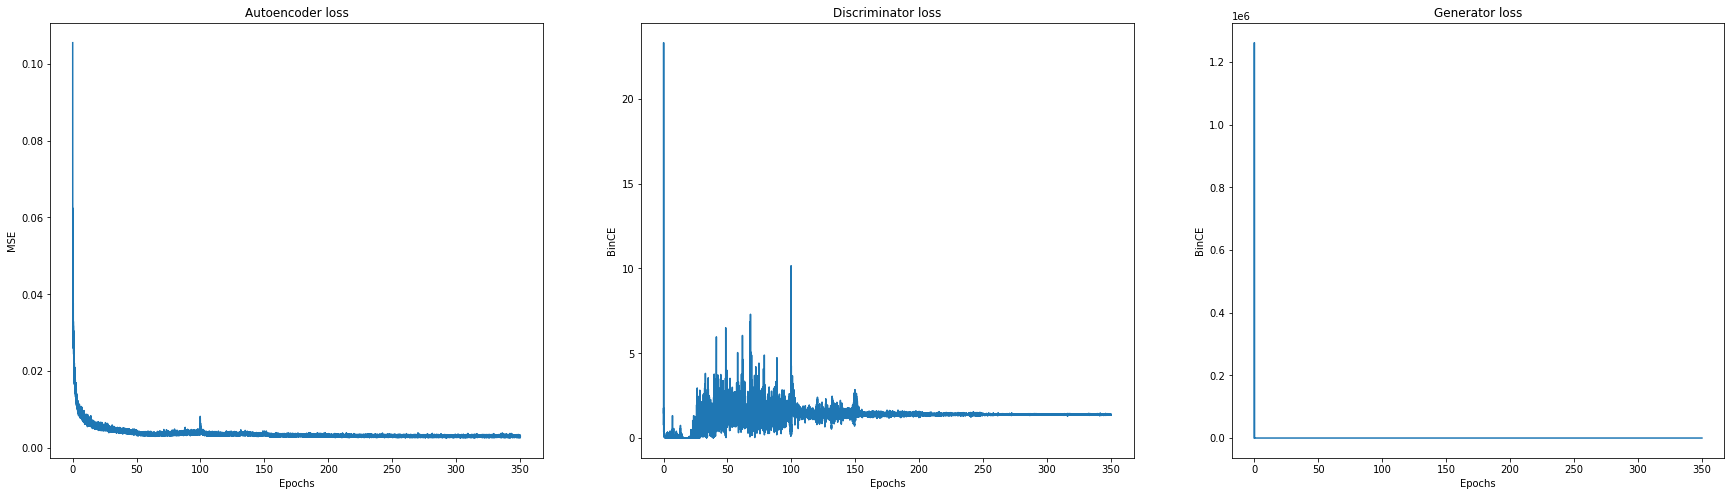

In [ ]:
steps_per_epoch = train_images.shape[0] / batch_size

F, ax = plt.subplots(1,3,figsize=(30,8))
ax[0].plot((np.arange(len(ae_loss_history))+1)/steps_per_epoch, ae_loss_history)
ax[0].set_title('Autoencoder loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('MSE')
ax[1].plot((np.arange(len(dc_loss_history))+1)/steps_per_epoch, dc_loss_history)
ax[1].set_title('Discriminator loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('BinCE')
ax[2].plot((np.arange(len(gen_loss_history))+1)/steps_per_epoch, gen_loss_history)
ax[2].set_title('Generator loss')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('BinCE')


In [ ]:
aae.encoder.save('enc_model')
aae.decoder.save('dec_model')
aae.discriminator.save('dc_model')

INFO:tensorflow:Assets written to: enc_model\assets
INFO:tensorflow:Assets written to: dec_model\assets
INFO:tensorflow:Assets written to: dc_model\assets


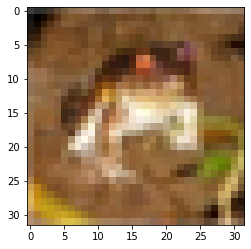

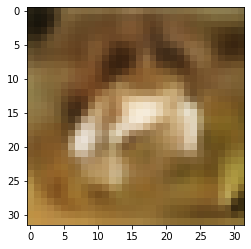

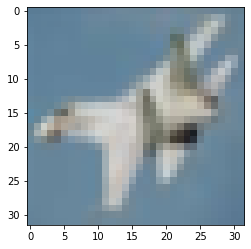

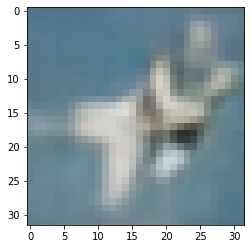

In [ ]:
image = train_images[0,:,:,:].reshape((1,32,32,3))
z = aae.encode(image)
image_recon = aae.decode(z, apply_sigmoid=True)
plt.figure()
plt.imshow(image[0,:,:,:])
plt.show()
plt.figure()
plt.imshow(image_recon[0,:,:,:])
plt.show()

image = test_images[10,:,:,:].reshape((1,32,32,3))
z = aae.encode(image)
image_recon = aae.decode(z, apply_sigmoid=True)
plt.figure()
plt.imshow(image[0,:,:,:])
plt.show()
plt.figure()
plt.imshow(image_recon[0,:,:,:])
plt.show()


In [ ]:
# Faccio il test error per batch perché sul mio PC la GPU va OOM
test_errors = []
for x_batch in test_dataset:
    test_err = aae.autoencoder_loss(x_batch)
    test_errors.append(test_err)
test_err = np.mean(test_errors)
print(test_err)

0.005187903


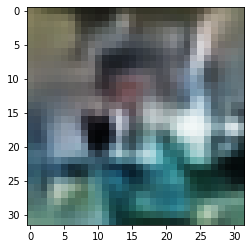

tf.Tensor([[-0.06222767]], shape=(1, 1), dtype=float32)


In [ ]:
z = np.random.randn(1,latent_dim)
image = aae.decode(z, apply_sigmoid=True).numpy()
image = image * 255.
image=image.astype('int16')
image.reshape((32,32,3))
plt.figure()
plt.imshow(image[0,:,:,:])
plt.show()
print(aae.discriminator(z))

In [ ]:
X = train_images[128].reshape((1,32,32,3))
z = aae.encode(X)
print(z)
vote = aae.discriminator(z)
print(vote)

tf.Tensor(
[[ 1.2126051  -1.7832106  -1.6065842  -0.16331774 -0.80528677  0.37527376
  -0.06717541  0.8919556   0.2554289  -0.2522458   0.06882773  0.5477136
   1.6850568  -0.63892335  0.2792959   0.33204997 -0.48208943 -1.8396233
  -0.69174206  0.4137604   0.98666185 -0.62334436 -1.5258129   1.0976706
  -1.2101438  -0.99224395  1.2468473  -0.7797065   0.8026567   0.5766202
   0.63166517 -0.35634208  1.6341988   1.8481796   0.12649684  0.26415336
  -0.86478734 -1.1436819   1.5804167  -3.1865602   0.2612761  -1.2258674
   0.42571574 -1.4622165   0.05367631 -0.8976999  -0.63343394  1.4589099
  -0.12919848 -0.01126537  1.0699127  -1.0219493   1.4241214   0.5200544
  -0.40811545 -0.5192904  -0.90120655  0.53553116  0.7630991   1.0101581
  -0.7529751   1.117023    0.17161152 -0.22013032  0.23470591 -2.01779
   0.47821975  0.1000616  -0.62826985  1.2116696  -0.3841853  -0.20593017
   1.1048151  -1.0308306   0.31817818 -0.30249298  1.2221066   0.06377734
  -1.8256338  -1.3983983  -1.0400631  

In [ ]:
minidc_dims=np.array([[30,30],[30,30]])

base_lr = 0.001
max_lr = 0.0025
step_size = 2 * np.ceil(train_images.shape[0] / batch_size)
epochs = 350

latent_dim = 192
alpha_leaky = 0.2
filters = [64,128,256,512]
kernel_size = [4,4,3,3]
strides = [2,2,2,2]
dense_units = [1000,300]
discriminator_units = [200, 200]
keep_prob = 0.5
gen_coef = 2.

steps_per_epoch = train_images.shape[0] / batch_size

aae_new = AAE((length, width, channels), latent_dim, alpha_leaky, filters, kernel_size, strides, dense_units, discriminator_units, keep_prob, minidc_dims, base_lr, max_lr, step_size, gen_coef)

In [ ]:
def plot_latent(aae, data, labels):
    latent_data = aae.encode(data)
    plt.scatter(latent_data[:,0], latent_data[:,1], c=labels)

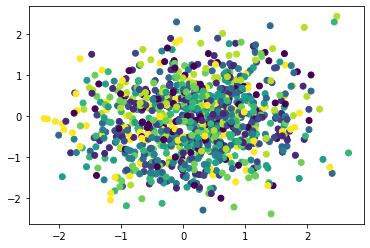

In [ ]:
plot_latent(aae_new, train_images[0:1000], train_labels[0:1000].reshape((1000)))